# Transitioning to autonomous driving: <br>Mixed vehicle autonomy levels on freeways
### Notebook to provide data analysis on the performed simulations.

Jesse Poland<br>
TU Delft<br>
Date: 02-10-2024<br>

## 0. Python packages and loading data files

First, Python packages are imported to provide specific functionalities within the notebook. Then, the file paths are set to retrieve stored simulation data for all experiment runs and seeds. The simulation data is loaded into Pandas DataFrames, making the data ready for analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from IPython.display import display

import random

In [2]:
# simulation output folder
# experiment_name = 'full_level_runs_1'
experiment_name = 'test_data'

# load Java simulation data
experiment_folder = fr'C:\Users\jesse\Documents\Java\TrafficSimulation-workspace\traffic-sim\src\main\resources\{experiment_name}'

# available files
input_values = 'inputValues.csv'
intermediate_output = 'intermediateOutputData.csv'
single_output = 'singleOutputData.csv'
sequence_output = 'sequenceOutputData.csv'
lane_change_output = 'laneChangeOutputData.csv'

In [3]:
# function to get a list of all file/folder names within a folder
def get_file_names(path):
    return os.listdir(path)

# load available seed folders
seed_folders = get_file_names(experiment_folder)

In [4]:
# function to retrieve any data within the project folder as dataframe
def load_dataframe(columns_of_interest, folder, file, input_file=None):
    # create empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in get_file_names(folder):
        # get all runs within this experiment
        run_folders = get_file_names(os.path.join(folder, seed_name))
        
        # go through all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            data_folder = os.path.join(folder, seed_name, run_folder)

            # open zip file (remove .csv form file name)
            try:
                with zipfile.ZipFile(os.path.join(data_folder, fr'{file[:-4]}.zip'), 'r') as zip_ref:
                    # read sequence csv
                    with zip_ref.open(file) as data_file:
                        df_run = pd.read_csv(data_file)
                        df_interest = df_run[columns_of_interest].copy()
                        df_interest['run'] = run_number
                # add input values to the dataframe if the input file is specified
                if input_file is not None:
                    # open input zip file
                    with zipfile.ZipFile(os.path.join(data_folder, fr'{input_file[:-4]}.zip'), 'r') as zip_ref:
                        # read input csv
                        with zip_ref.open(input_file) as input_data_file:
                            df_input = pd.read_csv(input_data_file)
                    # broadcast input data to all rows in df_interest
                    for col in df_input.columns:
                        df_interest[col] = df_input[col].iloc[0]

                # add this data to the main DataFrame
                df = pd.concat([df, df_interest])
            except:
                print(f'An error occured when trying to read data from: {data_folder}. This folder may contain a BadZipFile.')

    # return resulting DataFrame
    df.reset_index(drop=True, inplace=True)
    return df
    

In [5]:
# policy list
policies = [
        {'level0_fraction': 1.0, 'level1_fraction': 0, 'level2_fraction': 0, 'level3_fraction': 0,
                              'in_vehicle_distraction': True, 'road_side_distraction': False},
        {'level0_fraction': 0, 'level1_fraction': 1.0, 'level2_fraction': 0, 'level3_fraction': 0,
                              'in_vehicle_distraction': True, 'road_side_distraction': False},
        {'level0_fraction': 0, 'level1_fraction': 0, 'level2_fraction': 1.0, 'level3_fraction': 0,
                              'in_vehicle_distraction': True, 'road_side_distraction': False},
        {'level0_fraction': 0, 'level1_fraction': 0, 'level2_fraction': 0, 'level3_fraction': 1.0,
                              'in_vehicle_distraction': True, 'road_side_distraction': False},
    ]

In [ ]:
# function to compare acceleration values across penetration rates
def compare_variable_across_penetration_rates(df, variables, outliers):
    # group by vehicle penetration rate
    grouped_df = df.groupby(['level0_fraction', 'level1_fraction', 'level2_fraction', 'level3_fraction'])
    group_order = sorted(grouped_df.groups.keys(), key=lambda x: (x[0], x[1], x[2], x[3]), reverse=True)
    
    # show boxplots for speed
    for variable in variables:
        box_data = []
        box_labels = []
    
        # loop through each group and collect data for the current variable
        for name in group_order:
            group = grouped_df.get_group(name)
            box_data.append(group[variable].values)
            box_labels.append(f'{name}')
        
        # create boxplot
        if len(box_data) > 0:
            fig, ax = plt.subplots(figsize=(6, 4))
            ax.boxplot(box_data, tick_labels=box_labels, showfliers=outliers)
            ax.set_title(f'Boxplot for {variable} across penetration rate')
            ax.set_xlabel('Vehicle penetration rate (level0, level1, level2, level3)')
            ax.set_ylabel(variable)
            
            # display boxplot
            plt.tight_layout()
            plt.show()

## 1. Vehicle behaviour of automation levels in homogeneous traffic

### 1.1 Analyse headway

In [121]:
df_headway_time = load_dataframe(['time', 'gtu_id', 'gtu_type', 'headway_time'], experiment_folder, sequence_output, input_values)

In [130]:
print('DataFrame length: ' + str(len(df_headway_time)))
print(f'With {df_headway_time["headway_time"].isna().sum()} NaN values in headway_time')

DataFrame length: 1491454
With 25983 NaN values in headway_time


C:\Users\jesse\miniconda3\envs\thesisexperiments\lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


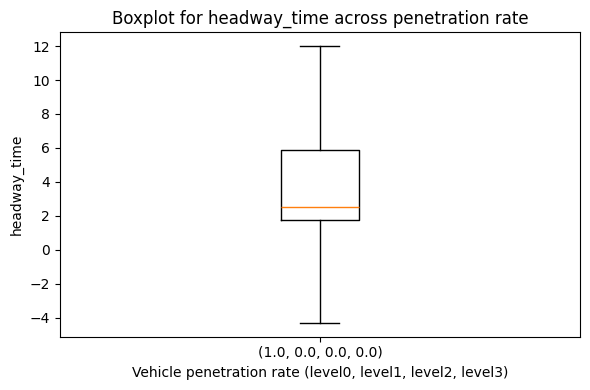

In [132]:
df_headway_time = df_headway_time.dropna()
compare_variable_across_penetration_rates(df_headway_time, ['headway_time'], False)

### 1.2 Analyse acceleration

In [113]:
df_acceleration = load_dataframe(['time', 'gtu_id', 'gtu_type', 'acceleration'], experiment_folder, sequence_output, input_values)

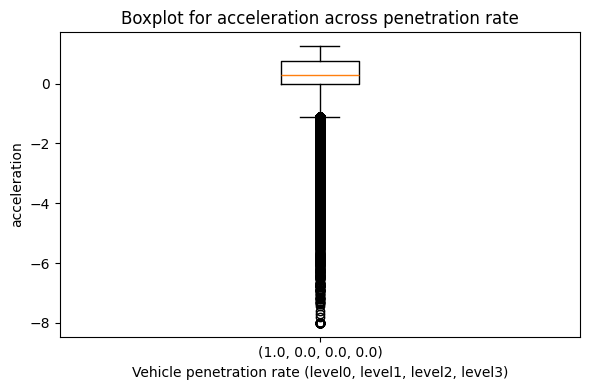

In [114]:
compare_variable_across_penetration_rates(df_acceleration, ['acceleration'], True)

In [115]:
# add delta column to DataFrame
def add_delta(df, variable):
    # new DataFrame
    df_new = pd.DataFrame()
    
    # group by run
    grouped_df = df.groupby(['seed', 'run'])
    group_order = sorted(grouped_df.groups.keys(), key=lambda x: (x[0], x[1]), reverse=True)
    
    # loop through each group
    for name in group_order:
        group = grouped_df.get_group(name)
        # group by vehicle
        vehicle_groups = group.groupby('gtu_id')
        # calculate the delta of the 'acceleration' column for each vehicle
        for gtu_id, vehicle_group in vehicle_groups:
            vehicle_group = vehicle_group.sort_values(by=['time'])
            vehicle_group[f'{variable}_delta'] = vehicle_group[variable].diff()
            # remove first row since it has no previous value to compare with
            vehicle_group = vehicle_group.iloc[1:]
            # add group to DataFrame
            df_new = pd.concat([df_new, vehicle_group])

    return df_new

In [116]:
df_acc_delta = df_acceleration.copy()
df_acc_delta = add_delta(df_acc_delta, 'acceleration')

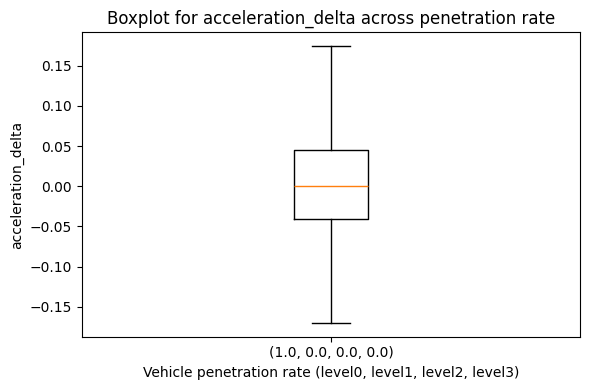

In [117]:
# show comparison
compare_variable_across_penetration_rates(df_acc_delta, ['acceleration_delta'], False)

### 1.3 Analyse switching leader vehicles

In [118]:
def count_gtu_leader_switches(df):
    # sort on time
    df = df.sort_values(by=['time'])
    # label changes in leader vehicle
    df['leader_switched'] = df['leader_gtu_id'] != df['leader_gtu_id'].shift(1)
    # track headway time just before the switches
    df['headway_before_switch'] = df['headway_time'].shift(1).where(df['leader_switched'], float('nan'))
    # remove first row
    df = df.iloc[1:]
    # count true values
    number_of_switches = len(df[df['leader_switched'] == True])
    # get mean headway time just before the switches
    headway_values = df['headway_before_switch'].dropna().values
    if len(headway_values) > 0:
        mean_headway = headway_values.mean()
    else:
        mean_headway = float('nan')
    # return
    return number_of_switches, mean_headway

In [119]:
# get data
df_leader_data = load_dataframe(['time', 'gtu_id', 'gtu_type', 'leader_gtu_id', 'leader_gtu_type', 'headway_time'], 
                            experiment_folder, sequence_output, input_values)

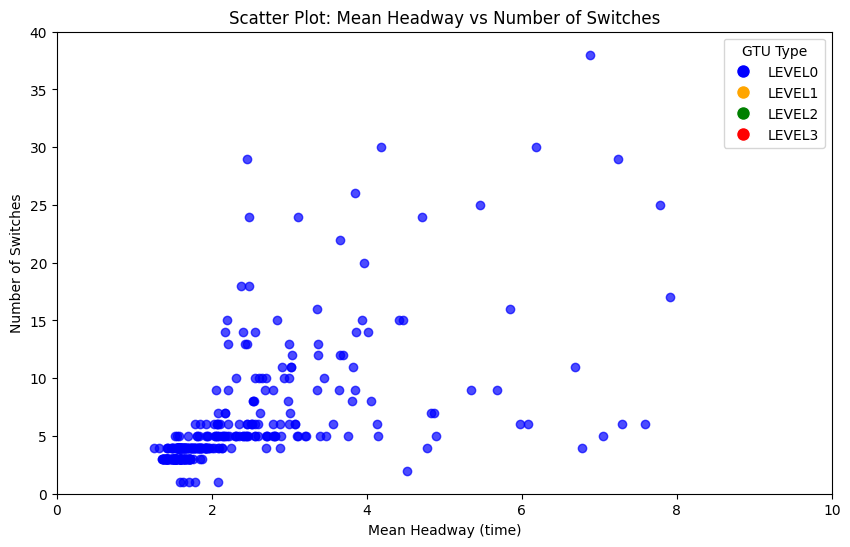

In [120]:
# choose run
df_leaders = df_leader_data.copy()
df_leaders = df_leaders[(df_leaders['seed'] == 0) & (df_leaders['run'] == 0)]

# save gtu switch numbers
switch_numbers = {}
gtu_types = {}
switch_mean_headway = {}

# pick 5 random GTUs
for i in range(500):
    # select a random gtu id
    random.seed(i)
    random_gtu_id = random.choice(df_leaders['gtu_id'].unique())
    # get gtu type
    random_gtu_type = df_leaders.loc[df_leaders['gtu_id'] == random_gtu_id, 'gtu_type'].iloc[5]
    # save gtu type
    gtu_types[random_gtu_id] = random_gtu_type
    # initialise switch count
    switch_numbers[random_gtu_id] = 0
    # filter on id
    df_gtu_leaders = df_leaders[(df_leaders['gtu_id'] == random_gtu_id) | (df_leaders['gtu_id'] == str(random_gtu_id))]
    # get switch count and mean headway before the switch
    num_switches, mean_headway = count_gtu_leader_switches(df_gtu_leaders)
    # save if the switch count is higher than 0
    if num_switches > 0:
        switch_numbers[random_gtu_id] = num_switches
    # save mean headway
    switch_mean_headway[random_gtu_id] = mean_headway

# show bar plot
# plt.figure(figsize=(18,6))
# plt.bar(switch_numbers.keys(), switch_numbers.values())
# plt.xlabel('GTU ID')
# plt.ylabel('Number of switches')
# plt.title('GTU leader switch Count')
# plt.show()

# level colors
color_mapping = {'LEVEL0': 'blue', 'LEVEL1': 'orange', 'LEVEL2': 'green', 'LEVEL3': 'red'}

# create plot
plt.figure(figsize=(10, 6))
for gtu_id, gtu_type in gtu_types.items():
    plt.scatter(switch_mean_headway[gtu_id], switch_numbers[gtu_id],
                color=color_mapping[gtu_type], label=gtu_type, alpha=0.7)

# set plot titles
plt.xlabel('Mean Headway (time)')
plt.ylabel('Number of Switches')
plt.title('Scatter Plot: Mean Headway vs Number of Switches')

# add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[gtu_type], markersize=10, label=gtu_type) 
           for gtu_type in color_mapping]
plt.legend(handles=handles, title='GTU Type')

# show plot
plt.xlim(0, 10)
plt.ylim(0, 40)
plt.show()

## 2. Vehicle behaviour of automation levels in heterogenous traffic

### 2.1 Analyse headway

In [133]:
mixed_policies = []

### 2.2 Analyse acceleration

In [134]:
# filter the DataFrame based on the selected policy
def filter_on_policy(df, policy_dict):
    df_filtered = df.copy()
    for key, value in policy_dict.items():
        df_filtered = df_filtered[df_filtered[key] == value]
        return df_filtered

In [144]:
# function to compare mean values
def compare_variable_across_levels(df, variables, outliers):
    # group by vehicle penetration rate
    grouped_df = df.groupby(['gtu_type'])
    group_order = sorted(grouped_df.groups.keys(), key=lambda x: (x[0], x[1], x[2], x[3]), reverse=True)
    
    # show boxplots for speed
    for variable in variables:
        box_data = []
        box_labels = []
    
        # loop through each group and collect data for the current variable
        for name in group_order:
            group = grouped_df.get_group(name)
            box_data.append(group[variable].values)
            box_labels.append(f'{name}')
        
        # create boxplot
        if len(box_data) > 0:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.boxplot(box_data, tick_labels=box_labels, showfliers=outliers)
            ax.set_title(f'Boxplot for {variable} across automation levels')
            ax.set_xlabel('Vehicle automation level')
            ax.set_ylabel(variable)
            
            # display boxplot
            plt.tight_layout()
            plt.show()

In [139]:
df_acceleration = load_dataframe(['time', 'gtu_id', 'gtu_type', 'acceleration'], experiment_folder, sequence_output, input_values)

C:\Users\jesse\AppData\Local\Temp\ipykernel_143464\1197303106.py:14: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = grouped_df.get_group(name)


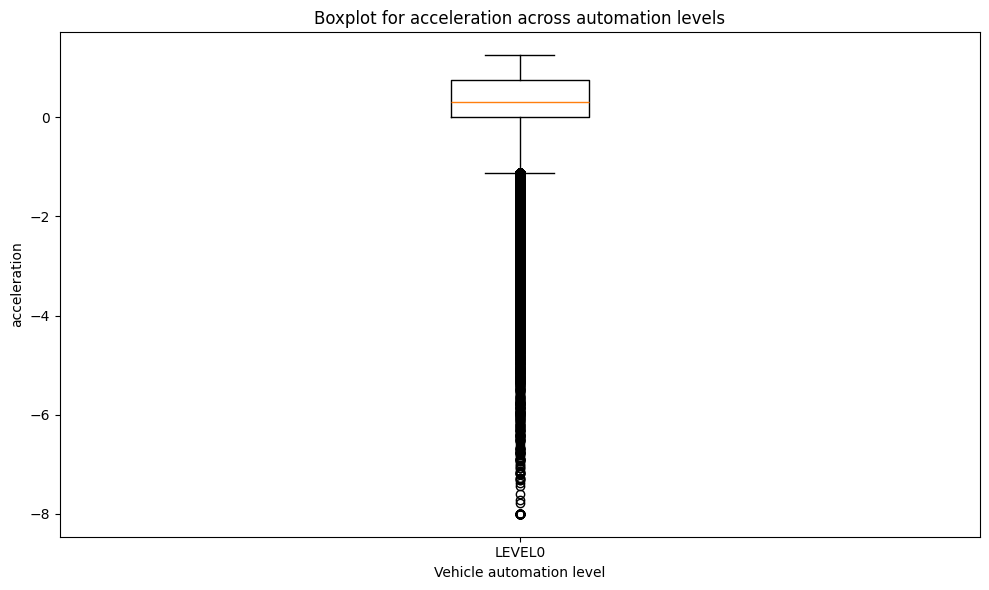

In [145]:
for policy in policies:
    df_acc_policy = filter_on_policy(df_acceleration, policy)
    compare_variable_across_levels(df_acc_policy, ['acceleration'], True)

In [147]:
df_acc_delta = df_acceleration.copy()
df_acc_delta = add_delta(df_acc_delta, 'acceleration')

C:\Users\jesse\AppData\Local\Temp\ipykernel_143464\1197303106.py:14: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group = grouped_df.get_group(name)


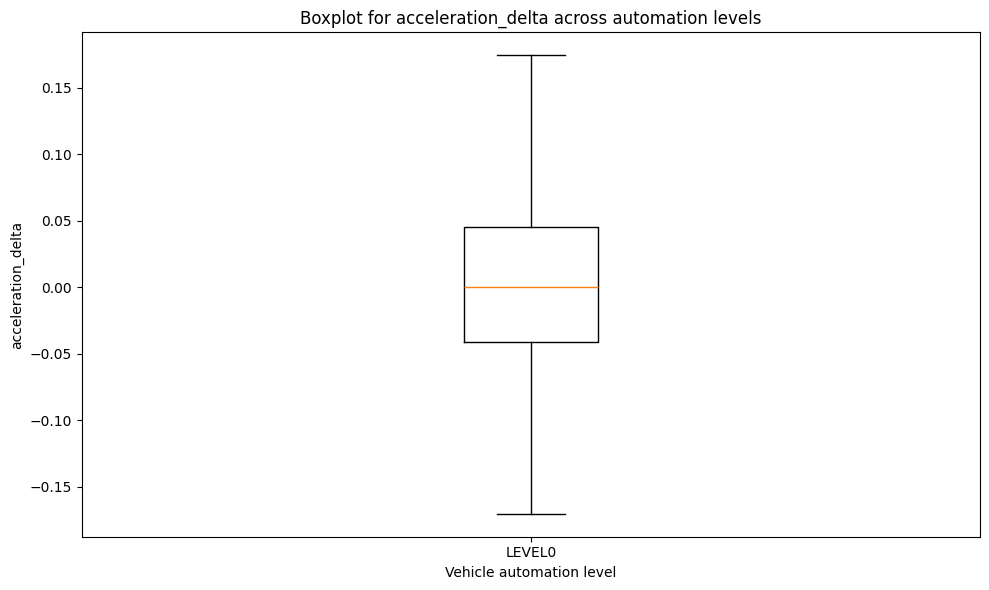

In [150]:
for policy in policies:
    df_acc_policy = filter_on_policy(df_acc_delta, policy)
    compare_variable_across_levels(df_acc_policy, ['acceleration_delta'], False)